In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.pyplot as plt

import os
import math
np.random.seed(2018)

D:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Read data:

In [2]:
batch_size = 32
input_size = (229, 229, 3)

train_img_gen = ImageDataGenerator()
val_img_gen = ImageDataGenerator()

train_data_gen = train_img_gen.flow_from_directory('train_split', (input_size[0], input_size[1]), class_mode='binary', batch_size=batch_size)
val_data_gen = val_img_gen.flow_from_directory('val_split', (input_size[0], input_size[1]), class_mode='binary', shuffle=False, batch_size=batch_size)


Found 19944 images belonging to 2 classes.
Found 4985 images belonging to 2 classes.


### Build model:

In [15]:
# base model
x_input = Input(input_size)
x_input = Lambda(xception.preprocess_input)(x_input)
base_model = Xception(input_tensor=x_input, weights='imagenet', include_top=False)
for layer in base_model.layers[:130]:
    layer.trainable = False
x = GlobalAveragePooling2D()(base_model.output)

# top layers
# top_model = load_model('Xception_top_layers.h5')

top_model = Sequential()
top_model.add(BatchNormalization(axis=1, name='top_bn_1', input_shape=(2048,)))
top_model.add(Dropout(0.8))
top_model.add(Dense(1024, activation=None, name='top_fc_1'))
top_model.add(BatchNormalization(axis=1, name='top_bn_2'))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.8))
top_model.add(Dense(1, activation='sigmoid', name='top_sigmoid'))
top_model.load_weights('Xception_top_layers_weights.h5')

x = top_model(x)

model = Model(base_model.input, x)
opt = optimizers.Adam(lr=1e-4, decay=1e-6)# momentum=0.9
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
print(len(base_model.layers))
print(len(model.layers))

for layer in model.layers:
    if layer.trainable:
        print(layer)

133
135


In [9]:
train_acc = model.evaluate_generator(train_data_gen, math.ceil(train_data_gen.samples/batch_size))
print('train acc: ', train_acc)
val_acc = model.evaluate_generator(val_data_gen, math.ceil(val_data_gen.samples/batch_size))
print('val acc: ', val_acc)

train acc:  [0.004919799395326995, 0.9992980344965905]
val acc:  [0.004125594657628844, 0.9989969909729187]


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 229, 229, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         lambda_2[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

### Train model:

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min'),
             ModelCheckpoint(filepath='Xception_model.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit_generator(train_data_gen, math.ceil(train_data_gen.samples/batch_size), epochs=50,
                    validation_data=val_data_gen, validation_steps=math.ceil(val_data_gen.samples/batch_size), callbacks=callbacks)


Epoch 1/50
624/624 [==============================] - 121s 194ms/step - loss: 0.1466 - acc: 0.9486 - val_loss: 0.1550 - val_acc: 0.9641
Epoch 2/50
624/624 [==============================] - 117s 187ms/step - loss: 0.1096 - acc: 0.9609 - val_loss: 0.1270 - val_acc: 0.9701
Epoch 3/50
624/624 [==============================] - 116s 186ms/step - loss: 0.0834 - acc: 0.9664 - val_loss: 0.1203 - val_acc: 0.9693
Epoch 4/50
624/624 [==============================] - 118s 189ms/step - loss: 0.0762 - acc: 0.9698 - val_loss: 0.1217 - val_acc: 0.9681
Epoch 5/50
624/624 [==============================] - 117s 188ms/step - loss: 0.0665 - acc: 0.9731 - val_loss: 0.1241 - val_acc: 0.9669
Epoch 6/50
624/624 [==============================] - 118s 188ms/step - loss: 0.0595 - acc: 0.9770 - val_loss: 0.1169 - val_acc: 0.9693
Epoch 7/50
624/624 [==============================] - 117s 188ms/step - loss: 0.0597 - acc: 0.9760 - val_loss: 0.1020 - val_acc: 0.9743
Epoch 8/50
624/624 [============================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


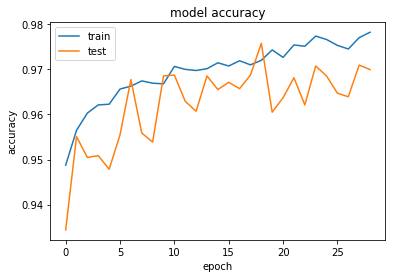

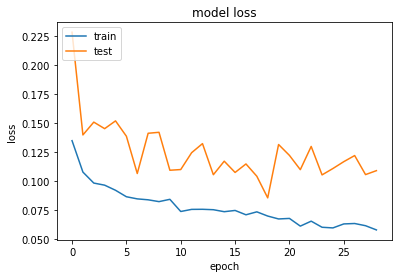

In [8]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model:

In [8]:
if os.path.isfile('Xception_model.h5'):
    os.remove('Xception_model.h5')

model.save_model('Xception_model.h5')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


AttributeError: 'Model' object has no attribute 'save_model'

### Train in total tarining data:

In [ ]:
batch_size = 16
input_size = (229, 229, 3)

img_gen = ImageDataGenerator()
total_train_data_gen = img_gen.flow_from_directory('train', (input_size[0], input_size[1]), class_mode='binary', batch_size=batch_size)

In [ ]:
model.fit_generator(total_train_data_gen, math.ceil(total_train_data_gen.samples/batch_size))

### Predict:

In [ ]:
img_gen = ImageDataGenerator()
test_data_gen = img_gen.flow_from_directory('test', (input_size[0], input_size[1]), shuffle=False, batch_size=batch_size)

In [ ]:
y_pred = model.predict(test_data_gen, math.ceil(test_data_gen.samples/batch_size), verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [ ]:
df = pd.read_csv("sampleSubmission.csv")

for i, fname in enumerate(test_data_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred[i]

df.to_csv('pred.csv', index=None)
df.head(10)
